# **RINGED SEAL OBJECT DETECCION MODELS PIPELINE-GUIDELINE**


# **1. Connect to Google Drive**

In my case, all datasets where link to my Google Drive.

If your datasets is located in your pc, you just need to uploaded directly to Google Colab.

If you are working locally, skip these steps.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1.1 Import dataset

In [2]:
################################IMPORTAR EL dataset entero a colab UNA VEZ TIENES LA ESTRUCTURA  ####################################################
####################################################################################


# Copiar el archivo data.yaml desde Drive a la ruta deseada en Colab
!cp -r "/content/drive/MyDrive/Seed_final/23_24_25/seed_plus_90_plus_z" "/content/dataset"

# Verificar que se copió correctamente
!ls -l "/content/dataset"

total 16
-rw------- 1 root root  236 Aug  4 16:42 data.yaml
drwx------ 3 root root 4096 Aug  4 16:45 hard_negatives
-rw------- 1 root root  948 Aug  4 16:42 README.roboflow.txt
drwx------ 4 root root 4096 Aug  4 16:43 train


# **2. Divide the dataset**

The chosen proportion is :

train: 70%

Valid: 15 %

Test : 15%

These percentages are customizables.

The division works adding 70 % os positives and 70 % of negatives to train set. Same process to other sets.

In [3]:
import os
import shutil
import random

# =============================
# CONFIGURACIÓN PERSONALIZABLE
# =============================

INPUT_IMAGES_DIR = "/content/dataset/train/images"
INPUT_LABELS_DIR = "/content/dataset/train/labels"
OUTPUT_BASE_DIR = "/content/mi_dataset_split"

INPUT_YAML_PATH = "/content/dataset/data.yaml"


SPLIT_RATIOS = {
    "train": 0.70,
    "valid": 0.15,
    "test":  0.15
}

SEED = 42

# =============================
# FUNCIONES AUXILIARES
# =============================

def is_positive(txt_path):
    if not os.path.exists(txt_path):
        return False
    with open(txt_path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 1 and parts[0].isdigit():
                return True  # Hay una clase → es positiva
    return False

def split_list(items, ratios):
    random.shuffle(items)
    n = len(items)
    n_train = int(n * ratios["train"])
    n_valid = int(n * ratios["valid"])
    return items[:n_train], items[n_train:n_train + n_valid], items[n_train + n_valid:]

def move_data_yaml_to_output(source_path, dest_dir):
    if not os.path.exists(source_path):
        print(f"❌ No se encontró el archivo data.yaml en: {source_path}")
        return
    os.makedirs(dest_dir, exist_ok=True)
    shutil.copy2(source_path, os.path.join(dest_dir, "data.yaml"))
    print(f"📄 Archivo data.yaml copiado a: {dest_dir}")

# =============================
# FUNCIÓN PRINCIPAL
# =============================

def split_dataset():
    for split in SPLIT_RATIOS:
        os.makedirs(os.path.join(OUTPUT_BASE_DIR, split, "images"), exist_ok=True)
        os.makedirs(os.path.join(OUTPUT_BASE_DIR, split, "labels"), exist_ok=True)

    all_images = [f for f in os.listdir(INPUT_IMAGES_DIR) if f.lower().endswith((".jpg", ".jpeg", ".png"))]
    all_images.sort()

    positives, negatives = [], []
    for img_name in all_images:
        txt_name = os.path.splitext(img_name)[0] + ".txt"
        txt_path = os.path.join(INPUT_LABELS_DIR, txt_name)
        if is_positive(txt_path):
            positives.append(img_name)
        else:
            negatives.append(img_name)

    print(f"📦 Total imágenes: {len(all_images)}")
    print(f"✅ Positivas: {len(positives)}")
    print(f"⭕ Negativas: {len(negatives)}")

    random.seed(SEED)

    pos_train, pos_valid, pos_test = split_list(positives, SPLIT_RATIOS)
    neg_train, neg_valid, neg_test = split_list(negatives, SPLIT_RATIOS)

    split_sets = {
        "train": {"images": pos_train + neg_train, "positives": pos_train, "negatives": neg_train},
        "valid": {"images": pos_valid + neg_valid, "positives": pos_valid, "negatives": neg_valid},
        "test":  {"images": pos_test + neg_test,   "positives": pos_test,  "negatives": neg_test}
    }

    for split, data in split_sets.items():
        for img_name in data["images"]:
            src_img = os.path.join(INPUT_IMAGES_DIR, img_name)
            dst_img = os.path.join(OUTPUT_BASE_DIR, split, "images", img_name)
            shutil.copy2(src_img, dst_img)

            txt_name = os.path.splitext(img_name)[0] + ".txt"
            src_lbl = os.path.join(INPUT_LABELS_DIR, txt_name)
            dst_lbl = os.path.join(OUTPUT_BASE_DIR, split, "labels", txt_name)

            if os.path.exists(src_lbl):
                shutil.copy2(src_lbl, dst_lbl)
            else:
                open(dst_lbl, "w").close()

    print("\n✅ División completada con éxito:")
    for s in ["train", "valid", "test"]:
        total = len(split_sets[s]["images"])
        pos = len(split_sets[s]["positives"])
        neg = len(split_sets[s]["negatives"])
        print(f"📁 {s.upper():<5}: {total} imágenes → {pos} positivas / {neg} negativas")

    # Copiar data.yaml al directorio final
    move_data_yaml_to_output(INPUT_YAML_PATH, OUTPUT_BASE_DIR)

     # Copiar carpeta de hard negatives si existe
    hard_neg_src = "/content/dataset/hard_negatives"
    hard_neg_dst = os.path.join(OUTPUT_BASE_DIR, "hard_negatives")
    if os.path.exists(hard_neg_src):
        print(f"📁 Copiando carpeta de hard negatives a: {hard_neg_dst}")
        shutil.copytree(hard_neg_src, hard_neg_dst, dirs_exist_ok=True)
    else:
        print("⚠️ No se encontró la carpeta de hard negatives. Se omite copia.")

# =============================
# EJECUTAR
# =============================

split_dataset()


📦 Total imágenes: 830
✅ Positivas: 620
⭕ Negativas: 210

✅ División completada con éxito:
📁 TRAIN: 581 imágenes → 434 positivas / 147 negativas
📁 VALID: 124 imágenes → 93 positivas / 31 negativas
📁 TEST : 125 imágenes → 93 positivas / 32 negativas
📄 Archivo data.yaml copiado a: /content/mi_dataset_split
📁 Copiando carpeta de hard negatives a: /content/mi_dataset_split/hard_negatives


# 2.1 Save the divided datasets, if desired

In [ ]:
# 10. Guardar los resultados del experimento

# Define la carpeta de destino en Google Drive
dest_folder = "/content/drive/MyDrive/Seed_final/25"
!mkdir -p "{dest_folder}"  # El comando mkdir -p crea esa carpeta (y cualquier subcarpeta necesaria) si no existe.

# Copia la carpeta de resultados (ajusta el nombre según el que se haya generado)
!cp -r "/content/mi_dataset_split" "{dest_folder}/"  # Copiar los resultados del modelo en drive

# Comprueba que se copiaron los archivos (opcional)
!ls "{dest_folder}"

mi_dataset_split  seed_2025_plus_90_and_2022_and90_2022


# **3. Pipeline for preparing the dataset prior to training**

# 3.1 Import and install required libraries



In [4]:
!pip install opencv-python-headless albumentations

# 3.2 Run the pipeline

Customizable parameters:

- Tile size
- Overlap
- Positive / negative Proportion in the final sets (train, valid, test)
- Augmentation process for positive images in train
- Number of augmented images per positive image
- Presence of hard negatives
- Percentage of hard negatives to normal negaives in each set
- Percentaje of each set regarding the total ( once again, train 70%, valid 15 %, test 15%)
- Specific final number of tiles in the valid and test set (for the amplification evaluation on miniSeal test set)
- Input and output directories
- Clean intermediate tiles generated throughout the pipeline

In [5]:
import os
import cv2
import albumentations as A
import random
import shutil
import numpy as np
import torch

# Fijar la semilla para reproducibilidad
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# --- CONFIGURACIÓN (editable) ---
BASE_DATASET_DIR = "/content/mi_dataset_split"
EXPORT_DIR = "/content/export_yolov8"
IMAGE_EXTENSIONS = (".jpg", ".jpeg", ".png")

# Parámetros para tiling
TILE_SIZE = 640
OVERLAP = 128


# Proporción deseada de positivos/negativos totales para el conjunto de TRAIN
NEGATIVE_MULTIPLIER = 9  # esto asegura 1 positivo por cada 8 negativos, ratio 1:8 o 1/9

APPLY_AUGMENTATION = True
AUGMENTATIONS_MIN = 6
AUGMENTATIONS_MAX = 6

# Carpeta de hard negatives (falsos positivos extraídos de una primera inferencia)
FORCED_NEGATIVES_SUBFOLDER = "hard_negatives"

# Porcentaje de hard negatives sobre el *total de negativos* para cada split.
HARD_NEG_PERCENTAGE_TRAIN = 0.30
HARD_NEG_PERCENTAGE_VALID = 0.10
HARD_NEG_PERCENTAGE_TEST = 0.10

 #!!! NUEVAS VARIABLES DE CONFIGURACIÓN PARA PORCENTAJES PROPORCIONALES !!!
# Estos porcentajes se usarán SOLO si VALID_TARGET_COUNT o TEST_TARGET_COUNT son None.
TRAIN_SET_PERCENTAGE = 0.70 # Porcentaje del dataset total para entrenamiento (0.70 = 70%)
VALID_SET_PERCENTAGE = 0.15 # Porcentaje del dataset total para validación (0.15 = 15%)
TEST_SET_PERCENTAGE = 0.15  # Porcentaje del dataset total para test (0.15 = 15%)
# !!! FIN NUEVAS VARIABLES DE CONFIGURACIÓN PARA PORCENTAJES PROPORCIONALES !!!

# !!! NUEVAS VARIABLES DE CONFIGURACIÓN !!!
#ESTO ES PARA AMPLIFICACION, CUANDO QUIERES QUE EL TEST SET Y VALID SET TENGAN MISMO NUMERO QUE MINISEAL PERO CON TRAIN DE MEDIUMSEAL
# Si se establece un número entero, se usará como el tamaño fijo del split.
# Si se deja en None, se calculará como el 15% del tamaño final de TRAIN.
VALID_TARGET_COUNT = None   # Ejemplo: 6000 para un tamaño fijo de 6000 imágenes para VALID  @ al PONER None, vale para los demas datasets!########################333
TEST_TARGET_COUNT = None    # Ejemplo: None para que se calcule el 15% para TEST
# !!! FIN NUEVAS VARIABLES DE CONFIGURACIÓN !!!


# Rutas para el data.yaml:
INPUT_YAML_PATH = os.path.join(BASE_DATASET_DIR, "data.yaml")
EXPORT_YAML_PATH = os.path.join(EXPORT_DIR, "data.yaml")

# Control de limpieza de carpetas intermedias
CLEAN_INTERMEDIATE = False

# --- Fin de Configuración ---

# --- Funciones Auxiliares (mantienen el código existente) ---
def count_files(folder):
    """Cuenta el número de archivos en una carpeta."""
    if not os.path.exists(folder):
        return 0
    return len([f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))])

def polygon_to_bbox(coords):
    """
    Convierte una lista de coordenadas de un polígono [x1, y1, x2, y2, ..., xN, yN]
    a una bounding box en formato YOLO: (x_center, y_center, width, height).
    """
    if not coords or len(coords) % 2 != 0:
        return None
    xs = coords[0::2]
    ys = coords[1::2]
    if not xs or not ys:
        return None
    x_min, x_max = min(xs), max(xs)
    y_min, y_max = min(ys), max(ys)
    return (x_min + x_max) / 2, (y_min + y_max) / 2, x_max - x_min, y_max - y_min

def process_label_file(src_file, dst_file):
    """Procesa un archivo de etiqueta, convirtiendo polígonos a BBoxes si es necesario."""
    with open(src_file, 'r') as f_in:
        lines = f_in.readlines()
    new_lines = []
    for line in lines:
        parts = line.strip().split()
        if not parts:
            continue
        cls = parts[0]
        try:
            coords = list(map(float, parts[1:]))
        except Exception as e:
            print(f"Error procesando coordenadas en {src_file}: {e}")
            continue

        if len(coords) == 4:
            # Ya en formato bbox (x_center, y_center, w, h)
            new_line = f"{cls} {' '.join(f'{c:.16f}' for c in coords)}"
        else:
            bbox = polygon_to_bbox(coords)
            if bbox is None:
                print(f"Warning: No se pudo convertir el polígono en {src_file}. Línea saltada.")
                continue
            x_center, y_center, width, height = bbox
            new_line = f"{cls} {x_center:.16f} {y_center:.16f} {width:.16f} {height:.16f}"
        new_lines.append(new_line)
    with open(dst_file, 'w') as f_out:
        for new_line in new_lines:
            f_out.write(new_line + "\n")

def load_annotations(label_path, image_width, image_height):
    """Carga anotaciones YOLO de un archivo y las convierte a coordenadas absolutas."""
    annotations = []
    if not os.path.exists(label_path):
        return annotations
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if not parts:
                continue
            cls = parts[0]
            coords = list(map(float, parts[1:]))
            # Asume formato YOLO: x_center, y_center, w, h (normalizado)
            x_center, y_center, w, h = coords
            x1 = (x_center - w/2) * image_width
            y1 = (y_center - h/2) * image_height
            x2 = (x_center + w/2) * image_width
            y2 = (y_center + h/2) * image_height
            annotations.append((cls, x1, y1, x2, y2))
    return annotations

def adjust_annotation_for_tile(annotation, tile_x, tile_y, tile_size):
    """
    Ajusta una anotación al sistema de coordenadas locales del tile y la normaliza.
    Si la intersección es insuficiente o el tamaño es muy pequeño, retorna None.
    """
    cls, x1, y1, x2, y2 = annotation
    inter_x1 = max(x1, tile_x)
    inter_y1 = max(y1, tile_y)
    inter_x2 = min(x2, tile_x + tile_size)
    inter_y2 = min(y2, tile_y + tile_size)

    if inter_x2 <= inter_x1 or inter_y2 <= inter_y1:
        return None

    local_x1 = inter_x1 - tile_x
    local_y1 = inter_y1 - tile_y
    local_x2 = inter_x2 - tile_x
    local_y2 = inter_y2 - tile_y

    w = local_x2 - local_x1
    h = local_y2 - local_y1
    x_center = local_x1 + w / 2
    y_center = local_y1 + h / 2

    # Normalizar al tamaño del tile [0,1]
    norm_x = max(0.0, min(1.0, x_center / tile_size))
    norm_y = max(0.0, min(1.0, y_center / tile_size))
    norm_w = max(0.0, min(1.0, w / tile_size))
    norm_h = max(0.0, min(1.0, h / tile_size))

    # Umbral mínimo para evitar cajas insignificantes
    MIN_SIZE_RATIO = 0.01
    if norm_w < MIN_SIZE_RATIO or norm_h < MIN_SIZE_RATIO:
        return None
    return (cls, norm_x, norm_y, norm_w, norm_h)

def read_yolo_labels(label_path):
    """Lee etiquetas YOLO de un archivo."""
    bboxes, classes = [], []
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    classes.append(parts[0])
                    bboxes.append(list(map(float, parts[1:])))
    return bboxes, classes

def safe_copy(src_dir, dst_dir, extensions=None):
    """Copia archivos de forma segura, evitando sobrescrituras y filtrando por extensión."""
    copied = 0
    if not os.path.exists(src_dir):
        print(f"Warning: Directorio de origen no encontrado: {src_dir}. Se omite la copia.")
        return 0

    for fname in os.listdir(src_dir):
        if extensions and not fname.lower().endswith(extensions):
            continue
        src = os.path.join(src_dir, fname)
        dst = os.path.join(dst_dir, fname)

        # Si el destino ya existe, renombra para evitar conflictos
        if os.path.exists(dst):
            base, ext = os.path.splitext(fname)
            i = 1
            while os.path.exists(os.path.join(dst_dir, f"{base}_{i}{ext}")):
                i += 1
            dst = os.path.join(dst_dir, f"{base}_{i}{ext}")

        shutil.copy2(src, dst)
        copied += 1
    return copied

def select_and_copy_hard_negatives(num_needed, dest_img_dir, dest_lbl_dir,
                                     global_hard_images_pool,
                                     hard_negatives_used_tracker):
    """
    Selecciona `num_needed` hard negatives del pool global que aún no han sido usados
    y los copia al directorio de destino.
    Actualiza el tracker de hard negatives usados.
    """
    added_count = 0
    if num_needed <= 0 or not global_hard_images_pool:
        return 0

    available_hard = [f for f in global_hard_images_pool if f not in hard_negatives_used_tracker]

    if not available_hard:
        return 0

    if num_needed > len(available_hard):
        selected_to_add = available_hard
    else:
        random.seed(SEED)
        selected_to_add = random.sample(available_hard, num_needed)

    src_img_dir = os.path.join(BASE_DATASET_DIR, FORCED_NEGATIVES_SUBFOLDER, "tiles", "images")
    src_lbl_dir = os.path.join(BASE_DATASET_DIR, FORCED_NEGATIVES_SUBFOLDER, "tiles", "labels")

    for fname in selected_to_add:
        lbl_name = os.path.splitext(fname)[0] + ".txt"
        shutil.copy2(os.path.join(src_img_dir, fname), os.path.join(dest_img_dir, fname))
        shutil.copy2(os.path.join(src_lbl_dir, lbl_name), os.path.join(dest_lbl_dir, lbl_name))
        hard_negatives_used_tracker.add(fname)
        added_count += 1
    return added_count


# --- Pasos del Pipeline ---

def process_all_labels_for_set(set_name):
    """Convierte todas las etiquetas de polígonos a bounding boxes para un set."""
    print(f"\n🔄 Convirtiendo etiquetas de {set_name.upper()}...")
    src_dir = os.path.join(BASE_DATASET_DIR, set_name, "labels")
    dst_dir = os.path.join(BASE_DATASET_DIR, set_name, "bblabels")
    os.makedirs(dst_dir, exist_ok=True)
    for filename in os.listdir(src_dir):
        if filename.endswith(".txt"):
            process_label_file(os.path.join(src_dir, filename), os.path.join(dst_dir, filename))
    print(f"✅ [{set_name.upper()}] Conversión de etiquetas completada.")

def tile_and_separate(image_path, label_path, out_pos_img, out_pos_lbl, out_neg_img, out_neg_lbl, split_name="unknown"):
    """
    Genera tiles de una imagen y sus anotaciones, separándolos en positivos (con objetos)
    y negativos (sin objetos).
    """
    image = cv2.imread(image_path)
    if image is None:
        print(f"❌ No se pudo leer la imagen: {image_path}, se omite.")
        return 0, 0
    orig_h, orig_w = image.shape[:2]
    annotations = load_annotations(label_path, orig_w, orig_h)
    step = TILE_SIZE - OVERLAP
    count_pos, count_neg = 0, 0 # Initialize count_pos and count_neg
    base_name = os.path.splitext(os.path.basename(image_path))[0]
    tile_idx = 0

    log_dir = os.path.join(EXPORT_DIR, "errors")
    os.makedirs(log_dir, exist_ok=True)
    log_path = os.path.join(log_dir, "tiles_descartados.txt")
    discard_entries = []

    for y in range(0, orig_h, step):
        for x in range(0, orig_w, step):
            tile = image[y:min(y+TILE_SIZE, orig_h), x:min(x+TILE_SIZE, orig_w)]

            # Rellenar tile si es más pequeño que TILE_SIZE
            if tile.shape[0] < TILE_SIZE or tile.shape[1] < TILE_SIZE:
                padded = np.zeros((TILE_SIZE, TILE_SIZE, 3), dtype=tile.dtype)
                padded[0:tile.shape[0], 0:tile.shape[1]] = tile
                tile = padded

            tile_name = f"{base_name}_tile_{tile_idx}.jpg"
            label_name = f"{base_name}_tile_{tile_idx}.txt"
            tile_idx += 1

            valid_annots = []
            for ann in annotations:
                result = adjust_annotation_for_tile(ann, x, y, TILE_SIZE)
                if result:
                    valid_annots.append(result)

            if valid_annots:
                # Tile positivo (contiene objetos)
                cv2.imwrite(os.path.join(out_pos_img, tile_name), tile)
                with open(os.path.join(out_pos_lbl, label_name), 'w') as f:
                    for cls, xc, yc, w, h in valid_annots:
                        f.write(f"{cls} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}\n")
                count_pos += 1
            else:
                # Tile negativo (no contiene objetos)
                cv2.imwrite(os.path.join(out_neg_img, tile_name), tile)
                open(os.path.join(out_neg_lbl, label_name), 'w').close()
                count_neg += 1
                discard_entries.append(
                    f"{tile_name} | de {base_name} @ x={x}, y={y} → {len(annotations)} cajas totales, 0 válidas."
                )

    if discard_entries:
        with open(log_path, "a") as log:
            log.write(f"\n🔹 TILES DESCARTADOS EN {split_name.upper()} (original: {base_name})\n")
            log.write("-" * 50 + "\n")
            for entry in discard_entries:
                log.write(entry + "\n")

    return count_pos, count_neg # Corrected: return count_pos and count_neg

def process_tiling_for_set(set_name):
    """Procesa el tiling para un set de datos (train, valid, test)."""
    print(f"\n📦 Procesando tiling para {set_name.upper()}...")
    input_img_dir = os.path.join(BASE_DATASET_DIR, set_name, "images")
    input_lbl_dir = os.path.join(BASE_DATASET_DIR, set_name, "bblabels")
    pos_img = os.path.join(BASE_DATASET_DIR, set_name, "tiles", "positives", "images")
    pos_lbl = os.path.join(BASE_DATASET_DIR, set_name, "tiles", "positives", "labels")
    neg_img = os.path.join(BASE_DATASET_DIR, set_name, "tiles", "negatives", "images")
    neg_lbl = os.path.join(BASE_DATASET_DIR, set_name, "tiles", "negatives", "labels")
    os.makedirs(pos_img, exist_ok=True)
    os.makedirs(pos_lbl, exist_ok=True)
    os.makedirs(neg_img, exist_ok=True)
    os.makedirs(neg_lbl, exist_ok=True)

    image_files = [f for f in os.listdir(input_img_dir) if f.lower().endswith(IMAGE_EXTENSIONS)]
    total_pos, total_neg = 0, 0
    for img_file in image_files:
        img_path = os.path.join(input_img_dir, img_file)
        lbl_path = os.path.join(input_lbl_dir, os.path.splitext(img_file)[0] + ".txt")
        pos, neg = tile_and_separate(img_path, lbl_path, pos_img, pos_lbl, neg_img, neg_lbl, split_name=set_name.upper())
        total_pos += pos
        total_neg += neg
    print(f"✅ {set_name.upper()}: {total_pos} tiles positivos, {total_neg} negativos (generados inicialmente).")

def process_forced_negatives_tiling():
    """Genera tiles de las imágenes de 'hard_negatives' (falsos positivos de inferencia previa)."""
    img_dir = os.path.join(BASE_DATASET_DIR, FORCED_NEGATIVES_SUBFOLDER, "train", "images")
    lbl_dir = os.path.join(BASE_DATASET_DIR, FORCED_NEGATIVES_SUBFOLDER, "train", "labels")

    if not os.path.exists(os.path.join(BASE_DATASET_DIR, FORCED_NEGATIVES_SUBFOLDER)):
        print(f"⚠️ Carpeta de negativos forzados '{FORCED_NEGATIVES_SUBFOLDER}' no encontrada en '{BASE_DATASET_DIR}'. Se omite este paso.")
        return

    if not os.path.exists(img_dir) or not os.path.exists(lbl_dir) or not any(f.lower().endswith(IMAGE_EXTENSIONS) for f in os.listdir(img_dir)):
        print(f"⚠️ No hay imágenes en la carpeta de negativos forzados: {img_dir}. Se omite este paso.")
        return

    print("\n🧩 Procesando TILES de negativos forzados (falsos positivos)...")

    out_img_dir = os.path.join(BASE_DATASET_DIR, FORCED_NEGATIVES_SUBFOLDER, "tiles", "images")
    out_lbl_dir = os.path.join(BASE_DATASET_DIR, FORCED_NEGATIVES_SUBFOLDER, "tiles", "labels")
    os.makedirs(out_img_dir, exist_ok=True)
    os.makedirs(out_lbl_dir, exist_ok=True)

    step = TILE_SIZE - OVERLAP
    total_tiles = 0

    for img_name in os.listdir(img_dir):
        if not img_name.lower().endswith(IMAGE_EXTENSIONS):
            continue

        img_path = os.path.join(img_dir, img_name)
        label_path = os.path.join(lbl_dir, os.path.splitext(img_name)[0] + ".txt")

        image = cv2.imread(img_path)
        if image is None:
            print(f"❌ No se pudo leer {img_name}, se omite.")
            continue

        h, w = image.shape[:2]
        base_name = os.path.splitext(img_name)[0]
        tile_idx = 0

        for y in range(0, h, step):
            for x in range(0, w, step):
                tile = image[y:min(y+TILE_SIZE, h), x:min(x+TILE_SIZE, w)]
                if tile.shape[0] < TILE_SIZE or tile.shape[1] < TILE_SIZE:
                    padded = np.zeros((TILE_SIZE, TILE_SIZE, 3), dtype=tile.dtype)
                    padded[0:tile.shape[0], 0:tile.shape[1]] = tile
                    tile = padded

                tile_name = f"{base_name}_tile_{tile_idx}.jpg"
                label_name = f"{base_name}_tile_{tile_idx}.txt"
                cv2.imwrite(os.path.join(out_img_dir, tile_name), tile)

                # For forced negatives, copy the existing label file (even if empty, usually they are)
                shutil.copy2(label_path, os.path.join(out_lbl_dir, label_name))
                tile_idx += 1

        total_tiles += tile_idx

    print(f"✅ TILES de negativos forzados completados: {total_tiles} tiles generados.")

def check_forced_tiles():
    """Verifica la cantidad de tiles de negativos forzados generados."""
    img_dir = os.path.join(BASE_DATASET_DIR, FORCED_NEGATIVES_SUBFOLDER, "tiles", "images")
    lbl_dir = os.path.join(BASE_DATASET_DIR, FORCED_NEGATIVES_SUBFOLDER, "tiles", "labels")

    n_img = count_files(img_dir) if os.path.exists(img_dir) else 0
    n_lbl = count_files(lbl_dir) if os.path.exists(lbl_dir) else 0

    print(f"\n🔍 Verificación TILES negativos forzados:")
    print(f"🖼️  Tiles: {n_img}")
    print(f"📄 Etiquetas (vacías): {n_lbl}")

# --- Data Augmentation ---
transform_pipeline = A.Compose([
    A.SomeOf([
        A.HorizontalFlip(p=1.0),
        A.Rotate(limit=(-5, 5), p=1.0),
        A.Affine(shear=(-5, 5), p=1.0),
        A.RandomBrightnessContrast(brightness_limit=(-0.05, 0.05), contrast_limit=(-0.05, 0.05), p=1.0),
        A.Blur(blur_limit=5, p=1.0),
        A.CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8)),
        A.ToGray(p=0.01, num_output_channels=3, method='weighted_average'),
    ], n=4, replace=True),
    A.Resize(TILE_SIZE, TILE_SIZE)
], bbox_params=A.BboxParams(format='yolo', label_fields=['labels']))

def augment_positives():
    """Aumenta los tiles positivos del conjunto de entrenamiento."""
    input_img_dir = os.path.join(BASE_DATASET_DIR, "train", "tiles", "positives", "images")
    input_lbl_dir = os.path.join(BASE_DATASET_DIR, "train", "tiles", "positives", "labels")
    output_img_dir = os.path.join(BASE_DATASET_DIR, "train", "tiles", "aug", "positives", "images")
    output_lbl_dir = os.path.join(BASE_DATASET_DIR, "train", "tiles", "aug", "positives", "labels")
    os.makedirs(output_img_dir, exist_ok=True)
    os.makedirs(output_lbl_dir, exist_ok=True)

    print("\n✨ Iniciando aumentación de datos para positivos de TRAIN...")

    for filename in os.listdir(input_img_dir):
        if not filename.lower().endswith(IMAGE_EXTENSIONS): continue
        img_path = os.path.join(input_img_dir, filename)
        label_path = os.path.join(input_lbl_dir, os.path.splitext(filename)[0] + ".txt")

        bboxes, classes = read_yolo_labels(label_path)

        # Always copy the original positive image and its label
        shutil.copy2(img_path, os.path.join(output_img_dir, filename))
        shutil.copy2(label_path, os.path.join(output_lbl_dir, os.path.splitext(filename)[0] + ".txt"))

        # Only apply augmentation if there are bboxes
        if len(bboxes) == 0:
            continue

        random.seed(SEED) # Ensure reproducibility of random number of augmentations
        num_variants = random.randint(AUGMENTATIONS_MIN, AUGMENTATIONS_MAX)

        for i in range(num_variants):
            image_bgr = cv2.imread(img_path)
            if image_bgr is None: continue
            image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

            try:
                # Use a different seed for each augmentation variant
                random.seed(SEED + i)
                np.random.seed(SEED + i)

                result = transform_pipeline(image=image_rgb, bboxes=bboxes, labels=classes)
            except Exception as e:
                print(f"Error aplicando aumentación en {filename}: {e}"); continue

            aug_img_rgb = result["image"]
            aug_bboxes = result["bboxes"]
            aug_labels = result["labels"]

            # Clipear las coordenadas de las bounding boxes para asegurar que estén dentro de [0.0, 1.0]
            clipped_bboxes = []
            for bbox in aug_bboxes:
                clipped_bbox = [max(0.0, min(1.0, val)) for val in bbox]
                clipped_bboxes.append(clipped_bbox)

            aug_img_bgr = cv2.cvtColor(aug_img_rgb, cv2.COLOR_RGB2BGR)

            new_img_name = f"{os.path.splitext(filename)[0]}_aug{i}.jpg"
            new_lbl_name = f"{os.path.splitext(filename)[0]}_aug{i}.txt"

            cv2.imwrite(os.path.join(output_img_dir, new_img_name), aug_img_bgr)

            with open(os.path.join(output_lbl_dir, new_lbl_name), 'w') as f:
                for cls, bbox in zip(aug_labels, clipped_bboxes):
                    f.write(f"{cls} {bbox[0]:.6f} {bbox[1]:.6f} {bbox[2]:.6f} {bbox[3]:.6f}\n")
    print("✅ Aumentación completada para positivos de TRAIN.")

def split_negatives(set_name, global_hard_images_pool, hard_negatives_used_tracker):
    """
    Gestiona la distribución inicial de negativos y hard negatives para cada set.
    Para TRAIN: selecciona hard negatives y normales y copia positivos.
    Para VALID/TEST: mueve todos los negativos a 'negatives_rest' para el rebalanceo posterior.
    """
    print(f"\n🔄 Preparando negativos para {set_name.upper()}...")

    pos_img_source_dir = (os.path.join(BASE_DATASET_DIR, set_name, "tiles", "aug", "positives", "images")
                            if APPLY_AUGMENTATION and set_name == "train"
                            else os.path.join(BASE_DATASET_DIR, set_name, "tiles", "positives", "images"))
    pos_lbl_source_dir = (os.path.join(BASE_DATASET_DIR, set_name, "tiles", "aug", "positives", "labels")
                            if APPLY_AUGMENTATION and set_name == "train"
                            else os.path.join(BASE_DATASET_DIR, set_name, "tiles", "positives", "labels"))

    neg_img_source_dir = os.path.join(BASE_DATASET_DIR, set_name, "tiles", "negatives", "images")
    neg_lbl_source_dir = os.path.join(BASE_DATASET_DIR, set_name, "tiles", "negatives", "labels")

    dest_final_img = os.path.join(BASE_DATASET_DIR, set_name, "tiles", "final_selection", "images")
    dest_final_lbl = os.path.join(BASE_DATASET_DIR, set_name, "tiles", "final_selection", "labels")
    os.makedirs(dest_final_img, exist_ok=True)
    os.makedirs(dest_final_lbl, exist_ok=True)

    dest_rest_img = os.path.join(BASE_DATASET_DIR, set_name, "tiles", "negatives_rest", "images")
    dest_rest_lbl = os.path.join(BASE_DATASET_DIR, set_name, "tiles", "negatives_rest", "labels")
    os.makedirs(dest_rest_img, exist_ok=True)
    os.makedirs(dest_rest_lbl, exist_ok=True)

    num_pos = count_files(pos_img_source_dir)
    all_neg_images_from_source = [f for f in os.listdir(neg_img_source_dir) if f.lower().endswith(IMAGE_EXTENSIONS)] if os.path.exists(neg_img_source_dir) else []

    num_total_neg_needed_initial = max(0, NEGATIVE_MULTIPLIER * num_pos - num_pos)

    # --- Lógica específica para TRAIN ---
    if set_name == "train":
        hard_neg_percentage = HARD_NEG_PERCENTAGE_TRAIN
        desired_hard_neg_count = int(num_total_neg_needed_initial * hard_neg_percentage)

        print(f"   [TRAIN]: Positivos: {num_pos}. Negativos iniciales necesarios para 1:{NEGATIVE_MULTIPLIER-1} de pos: {num_total_neg_needed_initial}.")

        # 1. Copiar los positivos (ya aumentados para TRAIN) a la carpeta final_selection
        print(f"   [TRAIN]: Copiando {num_pos} tiles positivos a la selección final.")
        for fname in os.listdir(pos_img_source_dir):
            if fname.lower().endswith(IMAGE_EXTENSIONS):
                shutil.copy2(os.path.join(pos_img_source_dir, fname), os.path.join(dest_final_img, fname))
                shutil.copy2(os.path.join(pos_lbl_source_dir, os.path.splitext(fname)[0] + ".txt"), os.path.join(dest_final_lbl, os.path.splitext(fname)[0] + ".txt"))

        # 2. Añadir hard negatives
        if hard_neg_percentage > 0:
            print(f"   [TRAIN]: Intentando añadir {desired_hard_neg_count} hard negatives ({hard_neg_percentage*100:.0f}% del total necesario).")
            added_hard = select_and_copy_hard_negatives(
                desired_hard_neg_count, dest_final_img, dest_final_lbl,
                global_hard_images_pool, hard_negatives_used_tracker
            )
            print(f"   [TRAIN]: Hard negatives añadidos: {added_hard}")
        else:
            added_hard = 0
            print("   [TRAIN]: Porcentaje de hard negatives es 0, no se añadirán.")

        total_negatives_for_train = max(0, num_pos * (NEGATIVE_MULTIPLIER - 1))
        normals_to_add = max(0, total_negatives_for_train - added_hard)

        available_normal_negatives = [f for f in all_neg_images_from_source if f not in hard_negatives_used_tracker]

        if normals_to_add > 0 and available_normal_negatives:
            random.seed(SEED)
            selected_normal_for_train = random.sample(
                available_normal_negatives, min(normals_to_add, len(available_normal_negatives))
            )
            print(f"   [TRAIN]: Añadiendo {len(selected_normal_for_train)} negativos normales.")
            for fname in selected_normal_for_train:
                shutil.copy2(os.path.join(neg_img_source_dir, fname), os.path.join(dest_final_img, fname))
                shutil.copy2(os.path.join(neg_lbl_source_dir, os.path.splitext(fname)[0] + ".txt"), os.path.join(dest_final_lbl, os.path.splitext(fname)[0] + ".txt"))
                hard_negatives_used_tracker.add(fname) # Track normal negatives too, so they aren't used again.

        remaining_negatives_after_train_selection = [f for f in all_neg_images_from_source if f not in hard_negatives_used_tracker]
        for fname in remaining_negatives_after_train_selection:
             shutil.copy2(os.path.join(neg_img_source_dir, fname), os.path.join(dest_rest_img, fname))
             shutil.copy2(os.path.join(neg_lbl_source_dir, os.path.splitext(fname)[0] + ".txt"), os.path.join(dest_rest_lbl, os.path.splitext(fname)[0] + ".txt"))

    # --- Lógica para VALID y TEST ---
    else:
        # Copiar los positivos a la carpeta final_selection
        print(f"   [{set_name.upper()}]: Copiando {num_pos} tiles positivos a la selección final.")
        for fname in os.listdir(pos_img_source_dir):
            if fname.lower().endswith(IMAGE_EXTENSIONS):
                shutil.copy2(os.path.join(pos_img_source_dir, fname), os.path.join(dest_final_img, fname))
                shutil.copy2(os.path.join(pos_lbl_source_dir, os.path.splitext(fname)[0] + ".txt"), os.path.join(dest_final_lbl, os.path.splitext(fname)[0] + ".txt"))

        print(f"   [{set_name.upper()}]: Moviendo todos los negativos a 'negatives_rest' para rebalanceo posterior.")
        for fname in all_neg_images_from_source:
            shutil.copy2(os.path.join(neg_img_source_dir, fname), os.path.join(dest_rest_img, fname))
            shutil.copy2(os.path.join(neg_lbl_source_dir, os.path.splitext(fname)[0] + ".txt"), os.path.join(dest_rest_lbl, os.path.splitext(fname)[0] + ".txt"))

    if CLEAN_INTERMEDIATE:
        # Make sure the paths exist before trying to remove them
        if os.path.exists(neg_img_source_dir):
            # Remove the parent directory 'negatives' which contains 'images' and 'labels'
            shutil.rmtree(os.path.dirname(neg_img_source_dir))
        if os.path.exists(pos_img_source_dir):
            # Remove the parent directory 'positives' or 'aug/positives'
            # Adjust path depending on augmentation being applied or not
            if set_name == "train" and APPLY_AUGMENTATION:
                shutil.rmtree(os.path.dirname(os.path.dirname(pos_img_source_dir))) # Removes 'aug' folder
            else:
                shutil.rmtree(os.path.dirname(pos_img_source_dir)) # Removes 'positives' folder

    print(f"✅ {set_name.upper()}: Negativos preparados. Contenido inicial en '{dest_final_img}' y '{dest_rest_img}'.")


def rebalance_validation_test_splits(global_hard_images_pool, hard_negatives_used_tracker):
    """
    Rebalancea los splits VALID y TEST para alcanzar las proporciones finales
    o el número de imágenes deseado, incluyendo los porcentajes de hard negatives.
    """
    print("\n⚖️ Iniciando rebalanceo de los splits VALID y TEST...")

    train_final_img_dir = os.path.join(BASE_DATASET_DIR, "train", "tiles", "final_selection", "images")
    final_train_size = count_files(train_final_img_dir)

    if final_train_size == 0:
        print("❌ El set de TRAIN está vacío o no se ha procesado correctamente. No se puede rebalancear VALID/TEST.")
        return

    print(f"📊 Tamaño final del set TRAIN: {final_train_size} imágenes.")

     # Calculate proportional targets if not explicitly set
    # El tamaño total del dataset se infiere de que TRAIN_SET_PERCENTAGE del total
    # debe ser igual al final_train_size.
    if TRAIN_SET_PERCENTAGE <= 0 or TRAIN_SET_PERCENTAGE > 1:
        raise ValueError("TRAIN_SET_PERCENTAGE debe ser un valor entre 0 y 1.")

    total_dataset_target = round(final_train_size / TRAIN_SET_PERCENTAGE)
    print(f"🎯 Tamaño total deseado del dataset: {total_dataset_target} imágenes (TRAIN {final_train_size} / {TRAIN_SET_PERCENTAGE*100:.0f}%).")

    # Determine target size for VALID
    if VALID_TARGET_COUNT is not None and isinstance(VALID_TARGET_COUNT, int) and VALID_TARGET_COUNT >= 0:
        valid_target_size = VALID_TARGET_COUNT
        print(f"🎯 Tamaño objetivo para VALID (fijo): {valid_target_size} imágenes.")
    else:
        # Usar el porcentaje configurable si no se ha fijado un tamaño
        valid_target_size = round(total_dataset_target * VALID_SET_PERCENTAGE)
        print(f"🎯 Tamaño objetivo para VALID (proporcional): {valid_target_size} imágenes ({VALID_SET_PERCENTAGE*100:.0f}% del total).")

    # Determine target size for TEST
    if TEST_TARGET_COUNT is not None and isinstance(TEST_TARGET_COUNT, int) and TEST_TARGET_COUNT >= 0:
        test_target_size = TEST_TARGET_COUNT
        print(f"🎯 Tamaño objetivo para TEST (fijo): {test_target_size} imágenes.")
    else:
        # Usar el porcentaje configurable si no se ha fijado un tamaño
        test_target_size = round(total_dataset_target * TEST_SET_PERCENTAGE)
        print(f"🎯 Tamaño objetivo para TEST (proporcional): {test_target_size} imágenes ({TEST_SET_PERCENTAGE*100:.0f}% del total).")


    # Adjust VALID target if necessary due to rounding (only if proportional calculation was used for both)
    # This adjustment is less critical if fixed counts are used, as we prioritize fixed counts.
    # We still want the total to make sense if both are proportional.
    if VALID_TARGET_COUNT is None and TEST_TARGET_COUNT is None:
        if (final_train_size + valid_target_size + test_target_size) != total_dataset_target:
            diff = total_dataset_target - (final_train_size + valid_target_size + test_target_size)
            if diff != 0:
                valid_target_size += diff # Adjust VALID to absorb rounding differences
                print(f"   Ajuste por redondeo: VALID target ajustado a {valid_target_size}")


    for split_name, target_size_config in [("valid", VALID_TARGET_COUNT), ("test", TEST_TARGET_COUNT)]:
        # Determine the actual target size for the current split based on config
        target_size = target_size_config if target_size_config is not None else \
                      (valid_target_size if split_name == "valid" else test_target_size)

        print(f"\n⚙️ Ajustando el split {split_name.upper()} con objetivo de {target_size} imágenes...")

        hard_neg_percentage = 0.0
        if split_name == "valid":
            hard_neg_percentage = HARD_NEG_PERCENTAGE_VALID
        elif split_name == "test":
            hard_neg_percentage = HARD_NEG_PERCENTAGE_TEST

        dest_final_img = os.path.join(BASE_DATASET_DIR, split_name, "tiles", "final_selection", "images")
        dest_final_lbl = os.path.join(BASE_DATASET_DIR, split_name, "tiles", "final_selection", "labels")

        neg_rest_img_dir = os.path.join(BASE_DATASET_DIR, split_name, "tiles", "negatives_rest", "images")
        neg_rest_lbl_dir = os.path.join(BASE_DATASET_DIR, split_name, "tiles", "negatives_rest", "labels")

        # Get current positive count in final_selection (these were copied by split_negatives)
        current_pos_count = 0
        if os.path.exists(dest_final_img):
            for fname in os.listdir(dest_final_img):
                if not fname.lower().endswith(IMAGE_EXTENSIONS):
                    continue

                label_fname = os.path.splitext(fname)[0] + ".txt"
                label_path = os.path.join(dest_final_lbl, label_fname)

                # A tile is considered "positive" if its label file exists and is not empty.
                if os.path.exists(label_path) and os.path.getsize(label_path) > 0:
                    current_pos_count += 1

        print(f"   {split_name.upper()}: Positivos actuales (ya en final_selection): {current_pos_count}")

        # Calculate how many total negatives are needed
        total_negatives_needed = max(0, target_size - current_pos_count)
        print(f"   {split_name.upper()}: Negativos totales necesarios para el objetivo ({target_size} total - {current_pos_count} pos): {total_negatives_needed}")

        # Add hard negatives first
        desired_hard_neg_count = int(total_negatives_needed * hard_neg_percentage)
        added_hard_count = 0

        if hard_neg_percentage > 0:
            print(f"   {split_name.upper()}: Hard negatives deseados ({hard_neg_percentage*100:.0f}% del total de negativos): {desired_hard_neg_count}")
            added_hard_count = select_and_copy_hard_negatives(
                desired_hard_neg_count, dest_final_img, dest_final_lbl,
                global_hard_images_pool, hard_negatives_used_tracker
            )
            print(f"   {split_name.upper()}: Hard negatives añadidos: {added_hard_count}")
        else:
            print(f"   {split_name.upper()}: Porcentaje de hard negatives es 0, no se añadirán.")

        # Calculate how many normal negatives are still needed after adding hard negatives
        current_total_count = count_files(dest_final_img)
        normals_to_add = max(0, target_size - current_total_count)

        all_rest_negatives_files = [f for f in os.listdir(neg_rest_img_dir) if f.lower().endswith(IMAGE_EXTENSIONS)] if os.path.exists(neg_rest_img_dir) else []

        # Filter out negatives that have already been used by TRAIN or by the current split (hard or normal)
        clean_rest_negatives_files = [f for f in all_rest_negatives_files if f not in hard_negatives_used_tracker]

        if normals_to_add > 0:
            if not clean_rest_negatives_files:
                print(f"   ⚠️ No hay negativos normales disponibles en '{neg_rest_img_dir}' para {split_name.upper()} para completar el objetivo.")
                print(f"   {split_name.upper()}: Se pudo añadir {current_total_count - current_pos_count} negativos (hard+normal). Faltan {normals_to_add} para el objetivo.")
            else:
                if normals_to_add > len(clean_rest_negatives_files):
                    print(f"   ⚠️ Solo hay {len(clean_rest_negatives_files)} negativos normales disponibles en 'negatives_rest' para {split_name.upper()}, pero se necesitan {normals_to_add}.")
                    files_to_move_normal = clean_rest_negatives_files
                else:
                    random.seed(SEED) # Ensure reproducibility for normal negative selection
                    files_to_move_normal = random.sample(clean_rest_negatives_files, normals_to_add)

                print(f"   {split_name.upper()}: Añadiendo {len(files_to_move_normal)} negativos normales adicionales de 'negatives_rest'.")

                for fname in files_to_move_normal:
                    src_img_path = os.path.join(neg_rest_img_dir, fname)
                    src_lbl_path = os.path.join(neg_rest_lbl_dir, os.path.splitext(fname)[0] + ".txt")

                    # Move, not copy, to ensure they are removed from 'negatives_rest'
                    shutil.move(src_img_path, os.path.join(dest_final_img, fname))
                    shutil.move(src_lbl_path, os.path.join(dest_final_lbl, os.path.splitext(fname)[0] + ".txt"))
                    hard_negatives_used_tracker.add(fname) # Track these as used too

        if CLEAN_INTERMEDIATE:
            # Check if the folder is empty before removing to prevent errors if already moved
            if os.path.exists(neg_rest_img_dir) and not os.listdir(neg_rest_img_dir):
                shutil.rmtree(os.path.dirname(neg_rest_img_dir)) # Removes 'negatives_rest' folder

        print(f"   ✅ {split_name.upper()}: Ajuste de negativos completado. Total final para exportación: {count_files(dest_final_img)} imágenes.")


def summary():
    """Muestra un resumen de los tiles en las carpetas de selección final."""
    print("\n📊 RESUMEN FINAL DE TILES (Antes de la exportación final)")
    for split in ["train", "valid", "test"]:
        print(f"\n📁 {split.upper()}")
        base = os.path.join(BASE_DATASET_DIR, split, "tiles")
        final_selection_img_dir = os.path.join(base, "final_selection", "images")
        final_selection_lbl_dir = os.path.join(base, "final_selection", "labels")

        img_count = count_files(final_selection_img_dir)
        lbl_count = count_files(final_selection_lbl_dir)

        print(f"Total en final_selection: {img_count} imágenes | {lbl_count} etiquetas")

        neg_rest_img_dir = os.path.join(base, "negatives_rest", "images")
        neg_rest_lbl_dir = os.path.join(base, "negatives_rest", "labels")
        rest_img_count = count_files(neg_rest_img_dir)
        rest_lbl_count = count_files(neg_rest_lbl_dir)
        if rest_img_count > 0:
            print(f"En negatives_rest (sobrantes): {rest_img_count} imágenes | {rest_lbl_count} etiquetas")


def export_for_yolov8(base_dataset_dir, export_dir):
    """Copia los archivos de la selección final a la estructura de exportación YOLOv8."""
    sets = ["train", "valid", "test"]
    os.makedirs(export_dir, exist_ok=True)

    print("\n📦 Iniciando export final para entrenamiento YOLOv8...\n")

    for split in sets:
        print(f"🔄 Procesando {split.upper()}...")

        split_dir = os.path.join(export_dir, split)
        images_dir = os.path.join(split_dir, "images")
        labels_dir = os.path.join(split_dir, "labels")
        os.makedirs(images_dir, exist_ok=True)
        os.makedirs(labels_dir, exist_ok=True)

        src_data_img = os.path.join(base_dataset_dir, split, "tiles", "final_selection", "images")
        src_data_lbl = os.path.join(base_dataset_dir, split, "tiles", "final_selection", "labels")

        count_imgs = safe_copy(src_data_img, images_dir, IMAGE_EXTENSIONS)
        count_lbls = safe_copy(src_data_lbl, labels_dir, (".txt",))

        print(f"✅ {split.upper()}: {count_imgs} imágenes, {count_lbls} labels exportados.")

    print(f"\n🚀 Export final completo en: {export_dir}")


def summary_export():
    """Muestra un resumen de los archivos en el directorio de exportación final."""
    print("\n📦 EXPORT FINAL PARA YOLOv8")
    for split in ["train", "valid", "test"]:
        exp_img = os.path.join(EXPORT_DIR, split, "images")
        exp_lbl = os.path.join(EXPORT_DIR, split, "labels")
        exp_img_count = count_files(exp_img)
        exp_lbl_count = count_files(exp_lbl)
        print(f"{split.upper():<7}: {exp_img_count} imágenes | {exp_lbl_count} etiquetas")


def move_data_yaml_to_export(source_path, dest_path):
    """Copia el archivo data.yaml al directorio de exportación."""
    if not os.path.exists(source_path):
        print(f"❌ No se encontró el archivo de entrada: {source_path}")
        return
    os.makedirs(os.path.dirname(dest_path), exist_ok=True)
    shutil.copy2(source_path, dest_path)
    print(f"✅ 'data.yaml' copiado a: {dest_path}")


def fix_discard_summary(log_path):
    """Consolida y formatea el resumen de tiles descartados."""
    if not os.path.exists(log_path):
        print("⚠️ No se encontró archivo de descartes.")
        return

    resumen_por_split = {}
    lines_to_write = []

    with open(log_path, "r") as f:
        lines = f.readlines()

    # Process lines to extract discarded counts per split
    current_split = None
    discard_count_for_current_split = 0
    for line in lines:
        if line.startswith("🔹 TILES DESCARTADOS EN"):
            # If we were tracking a previous split, save its count
            if current_split is not None:
                resumen_por_split[current_split] = resumen_por_split.get(current_split, 0) + discard_count_for_current_split

            # Start tracking new split
            split_name_start = line.find("EN ") + 3
            split_name_end = line.find(" (original:", split_name_start)
            current_split = line[split_name_start:split_name_end].strip()
            discard_count_for_current_split = 0 # Reset count for the new split
            lines_to_write.append(line) # Keep original line for context
        elif line.strip() == "-" * 50:
            lines_to_write.append(line) # Keep separator line
        elif current_split is not None and line.strip() and not line.startswith(("🔹 ", "📦 ", "🔸 ", "🧮 ")):
            discard_count_for_current_split += 1
            lines_to_write.append(line) # Keep discarded tile entry
        else:
            # Lines not related to discarded tiles, or already processed summary lines
            if not (line.startswith("📦 RESUMEN GLOBAL") or
                    line.startswith("🔸 ") or
                    line.startswith("🧮 ")):
                lines_to_write.append(line) # Keep other relevant lines

    # Add the last split's count if loop finishes
    if current_split is not None:
        resumen_por_split[current_split] = resumen_por_split.get(current_split, 0) + discard_count_for_current_split

    # Append the consolidated summary to the lines
    lines_to_write.append("\n📦 RESUMEN GLOBAL DE TILES DESCARTADOS\n")
    lines_to_write.append("=".ljust(50, "=") + "\n")

    total_global = 0
    for split, count in resumen_por_split.items():
        lines_to_write.append(f"🔸 {split}: {count} tiles descartados\n")
        total_global += count
    lines_to_write.append(f"\n🧮 TOTAL GLOBAL DE TILES DESCARTADOS: {total_global}\n")

    with open(log_path, "w") as f:
        f.writelines(lines_to_write)
    print(f"✅ Resumen de tiles descartados actualizado en: {log_path}")

def contar_imagenes_y_proporciones(export_dir):
    """Calcula y muestra la proporción final de imágenes en cada conjunto exportado."""
    sets = ["train", "valid", "test"]
    conteo = {}
    total = 0

    print("\n📊 PROPORCIÓN FINAL DE IMÁGENES POR CONJUNTO:")
    for split in sets:
        images_dir = os.path.join(export_dir, split, "images")
        if not os.path.exists(images_dir):
            print(f"⚠️ No existe la carpeta: {images_dir}")
            conteo[split] = 0
            continue
        n = len([f for f in os.listdir(images_dir) if f.lower().endswith(IMAGE_EXTENSIONS)])
        conteo[split] = n
        total += n

    for split in sets:
        porcentaje = (conteo[split] / total * 100) if total > 0 else 0
        print(f"{split.upper():<6}: {conteo[split]} imágenes ({porcentaje:.2f}%)")
    print(f"TOTAL: {total} imágenes")


# --- MAIN PIPELINE: ejecuta todo en orden ---
def run_full_pipeline():
    # --- Limpiar directorio de exportación si existe ---
    if os.path.exists(EXPORT_DIR):
        print(f"\n🗑️ Limpiando directorio de exportación existente: {EXPORT_DIR}")
        shutil.rmtree(EXPORT_DIR)
    os.makedirs(EXPORT_DIR, exist_ok=True)
    # --- Fin de limpieza ---

    # Paso 1: Convertir labels de polígono a BBoxes y Tiling inicial
    for split in ["train", "valid", "test"]:
        process_all_labels_for_set(split)
        process_tiling_for_set(split)

    # Paso 2: Procesar los hard negatives (si la carpeta existe)
    process_forced_negatives_tiling()
    global_hard_tiles_img_dir = os.path.join(BASE_DATASET_DIR, FORCED_NEGATIVES_SUBFOLDER, "tiles", "images")
    global_hard_images_pool = [f for f in os.listdir(global_hard_tiles_img_dir) if f.lower().endswith(IMAGE_EXTENSIONS)] if os.path.exists(global_hard_tiles_img_dir) else []
    # This set will track ALL hard/normal negatives that have been copied to 'final_selection' across ALL splits
    hard_negatives_used_tracker = set()
    check_forced_tiles()

    # Paso 3: Aumentación de datos para los positivos de TRAIN
    if APPLY_AUGMENTATION:
        augment_positives()

    # Paso 4: Selección de negativos para cada split (y copia de positivos a final_selection para todos los splits)
    # NOTA CLAVE: La función `split_negatives` ahora copia los positivos a `final_selection`
    # Esto asegura que el recuento para TRAIN sea preciso.
    for split in ["train", "valid", "test"]:
        split_negatives(split, global_hard_images_pool, hard_negatives_used_tracker)

    # Paso 5: Rebalanceo final para VALID y TEST
    rebalance_validation_test_splits(global_hard_images_pool, hard_negatives_used_tracker)

    # Paso 6: Resumen de los datos preparados antes de exportar
    summary()

    # Paso 7: Exportar los datos desde las carpetas 'final_selection'
    export_for_yolov8(BASE_DATASET_DIR, EXPORT_DIR)

    # Paso 8: Mover el archivo data.yaml
    move_data_yaml_to_export(INPUT_YAML_PATH, EXPORT_YAML_PATH)

    # Paso 9: Consolidar y limpiar el log de descartes
    fix_discard_summary(os.path.join(EXPORT_DIR, "errors", "tiles_descartados.txt"))

    # Paso 10: Contar y mostrar proporciones finales
    contar_imagenes_y_proporciones(EXPORT_DIR)


# --- Ejecutar el Pipeline Completo ---
if __name__ == "__main__":
    run_full_pipeline()


🔄 Convirtiendo etiquetas de TRAIN...
✅ [TRAIN] Conversión de etiquetas completada.

📦 Procesando tiling para TRAIN...
✅ TRAIN: 749 tiles positivos, 54587 negativos (generados inicialmente).

🔄 Convirtiendo etiquetas de VALID...
✅ [VALID] Conversión de etiquetas completada.

📦 Procesando tiling para VALID...
✅ VALID: 170 tiles positivos, 11630 negativos (generados inicialmente).

🔄 Convirtiendo etiquetas de TEST...
✅ [TEST] Conversión de etiquetas completada.

📦 Procesando tiling para TEST...
✅ TEST: 170 tiles positivos, 11734 negativos (generados inicialmente).

🧩 Procesando TILES de negativos forzados (falsos positivos)...
✅ TILES de negativos forzados completados: 32416 tiles generados.

🔍 Verificación TILES negativos forzados:
🖼️  Tiles: 32416
📄 Etiquetas (vacías): 32416

✨ Iniciando aumentación de datos para positivos de TRAIN...
Error aplicando aumentación en DSC01236_JPG-X-Amz-Algorithm-AWS4-HMAC-SHA256.rf.a8b8901a06dcfee367bd01a5abbfb5dd_tile_89.jpg: Expected x_min for bbox [-4

# **4. Install and import Ultralytics library for training**

In [6]:
#0. En Colab, primero instala los paquetes y monta tu Drive:  Instalar las librerías necesarias
!pip install ultralytics wandb  # Esto instalará ultralytics y wandb (torch y torchvision generalmente ya vienen instalados en Colab)

import ultralytics
ultralytics.checks()

Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Setup complete ✅ (12 CPUs, 83.5 GB RAM, 62.1/235.7 GB disk)


# 4.1 Install chosen YOLO version model and size

In [1]:

# 9. Ejecutar el entrenamiento de YOLOv8
from ultralytics import YOLO

# Carga el modelo (en este ejemplo, YOLOv8s)
model = YOLO("yolov8s.pt")



# 4.2 Train the chosen model and chose hyperparameter for training

In [2]:
model.train(
    project="ProSeal",
    name="seals",
    data="/content/export_yolov8/data.yaml",  # Asegúrate de que data.yaml use rutas correctas para Colab
    epochs=120,                                                # Número total de épocas (pasadas completas por el dataset de entrenamiento)
    imgsz=640,                                                  # Tamaño de la imagen (se reescala a 640x640)
    batch=32,                                                   # Número de imágenes por batch
    lr0=0.0001,                                                 # Tasa de aprendizaje inicial. Un valor mayor hace que los pesos se actualicen más rápido, pero puede inestabilizar el entrenamiento.
    momentum=0.937,                                             # Momentum para el optimizador (por ejemplo, en SGD)endizaje y otros parámetros (como el momentum) se ajustan gradualmente.    Esto ayuda a estabilizar el entrenamiento y a evitar que el modelo se desvíe demasiado al principio.
    warmup_momentum=0.8,                                        # La fase de "warmup" es un período inicial en el que la tasa de apr
    optimizer="adamw",                                          # Se usa AdamW (una variante de Adam que incorpora weight decay para evitar sobreajuste)
    weight_decay=0.002,                                         # Penalización sobre los pesos para prevenir sobreajuste. Si es muy alto, pdificultar euede l aprendizaje; si es muy bajo, el modelo puede sobreajustarse.                                          # Se usa AdamW (una variante de Adam que incorpora weight decay para evitar sobreajuste)
    #augment=False,                                             # Desactiva el data augmentation on the fly de YOLO##############  asi puedo hacer yo la data augmentation con las fotos con labels
    half=True,                                                  # Activa precisión mixta (FP16) para GPU
    workers=8,                                                  # Número de workers para el DataLoader
    device='cuda' ,                                             # Fuerza el uso de GPU lo que acelera el entrenamiento
    mosaic=1,                                                   # Desactivar si las imágenes son muy homogéneas, es un data augmentation process
    #resume=True,                                               # PARA seguir entrenamiento donde lo dejaste
    #validate=False                                             # para no hacer validación a la vez que entrena
    patience=13,                                                # epochs extra desde que converge para ver si aprende , si no aprende en 3 epochs más, se para. si tras "X" epochs la métrica val/best_map_50 no mejora, se detiene el entrenamiento automáticamente.
    cos_lr=True,                                                # scheduler
    plots=True,                                                 # generar gráficas de plots de learning rate
    #wandb=True,                                                # Activa integración con W&B
    #copy_paste=True,
    dfl= 1.75,
    warmup_epochs= 4,
    lrf= 0.01,
    flipud= 0.3,
    degrees=10,
    seed=42
)

Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/content/export_yolov8/data.yaml, degrees=10, deterministic=True, device=0, dfl=1.75, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=120, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.3, format=torchscript, fraction=1.0, freeze=None, half=True, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1, multi_scale=False, name=seals2, nbs=64, nms=False, opset=None, optimize=False, optimizer=adamw, overlap_mask=True, patience=13, perspective=0.0, plots=True, pose=12

train: Scanning /content/export_yolov8/train/labels... 46701 images, 41546 backgrounds, 0 corrupt: 100%|██████████| 46701/46701 [00:21<00:00, 2220.50it/s]


train: New cache created: /content/export_yolov8/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 783.8±321.6 MB/s, size: 30.1 KB)


val: Scanning /content/export_yolov8/valid/labels... 10008 images, 9838 backgrounds, 0 corrupt: 100%|██████████| 10008/10008 [00:04<00:00, 2216.01it/s]


val: New cache created: /content/export_yolov8/valid/labels.cache
Plotting labels to ProSeal/seals2/labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.002), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to ProSeal/seals2
Starting training for 120 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/120      6.68G      1.936      11.12      1.355          1        640: 100%|██████████| 1460/1460 [03:37<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:16<00:00,  9.63it/s]

                   all      10008        185      0.715       0.65      0.674      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/120      8.22G      1.727      1.145      1.249          2        640: 100%|██████████| 1460/1460 [03:36<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:16<00:00,  9.35it/s]


                   all      10008        185      0.778      0.703      0.676      0.246

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/120      8.27G      1.647     0.9526      1.235          2        640: 100%|██████████| 1460/1460 [03:22<00:00,  7.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.10it/s]

                   all      10008        185      0.902      0.768      0.829      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/120      8.31G      1.631     0.9446      1.218          1        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00,  9.97it/s]

                   all      10008        185      0.897      0.816      0.841      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/120      8.34G      1.593     0.9104      1.198          0        640: 100%|██████████| 1460/1460 [03:22<00:00,  7.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.14it/s]

                   all      10008        185      0.859      0.805      0.827      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/120      8.38G      1.553     0.8701      1.183          1        640: 100%|██████████| 1460/1460 [03:22<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.17it/s]

                   all      10008        185      0.886      0.758      0.817      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/120      8.42G      1.557     0.8572      1.195          5        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.06it/s]

                   all      10008        185      0.916      0.832       0.88      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/120      8.45G      1.528     0.8321      1.167          1        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00,  9.93it/s]


                   all      10008        185       0.88       0.83      0.868      0.398

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/120      8.49G      1.488     0.8101      1.149          1        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.14it/s]

                   all      10008        185      0.878      0.818      0.845      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/120      8.52G      1.472     0.7818      1.151          2        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.14it/s]

                   all      10008        185      0.902      0.797       0.87      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/120      8.56G      1.457     0.7786      1.141          1        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.25it/s]

                   all      10008        185      0.906      0.805      0.847      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/120       8.6G      1.461     0.7683      1.138          2        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.20it/s]

                   all      10008        185      0.872      0.827       0.86      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/120      8.63G      1.461     0.7639      1.145          0        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.20it/s]

                   all      10008        185      0.918      0.805      0.855      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/120      8.67G      1.429     0.7501      1.134          3        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.19it/s]

                   all      10008        185      0.924      0.843      0.885      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/120      8.71G      1.414     0.7438      1.118          4        640: 100%|██████████| 1460/1460 [03:22<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.21it/s]

                   all      10008        185      0.902      0.847      0.871      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/120      8.74G        1.4     0.7341      1.117          0        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.26it/s]

                   all      10008        185      0.883      0.857      0.876      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/120      8.78G      1.392      0.715      1.118          1        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.16it/s]

                   all      10008        185      0.911      0.827      0.873      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/120      8.81G      1.372      0.716      1.107          1        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.11it/s]

                   all      10008        185       0.92      0.827      0.875      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/120      8.85G      1.363     0.6994      1.114          2        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.22it/s]

                   all      10008        185      0.915      0.819      0.858      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/120      8.89G      1.347      0.678      1.099          2        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.23it/s]

                   all      10008        185      0.903      0.827      0.859       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/120      8.92G      1.364     0.6883      1.109          2        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.29it/s]

                   all      10008        185      0.936      0.822      0.874      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/120      8.96G       1.33     0.6802      1.096          2        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.13it/s]

                   all      10008        185       0.93      0.827      0.864      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/120         9G      1.327     0.6607      1.101          6        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.13it/s]

                   all      10008        185      0.938      0.824      0.875       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/120      9.03G      1.321     0.6591       1.09          3        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.25it/s]

                   all      10008        185      0.938      0.822      0.872      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/120      9.07G      1.319     0.6637      1.093          7        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.17it/s]

                   all      10008        185      0.934      0.827      0.881      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/120       9.1G      1.301     0.6554      1.085          1        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.18it/s]

                   all      10008        185      0.925      0.822      0.874      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/120      9.14G      1.291     0.6492      1.087          2        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.32it/s]

                   all      10008        185      0.898      0.849      0.875      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/120      9.18G      1.285     0.6295      1.079          2        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.24it/s]

                   all      10008        185      0.933      0.822      0.874      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/120      9.21G       1.27     0.6256      1.076          0        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.25it/s]

                   all      10008        185      0.932      0.822      0.873      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/120      9.25G      1.278     0.6313      1.088          4        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.22it/s]

                   all      10008        185      0.936      0.822      0.872      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/120      9.28G      1.265      0.616      1.081          0        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.17it/s]

                   all      10008        185      0.945      0.834      0.887       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/120      9.32G      1.244     0.6112       1.07          1        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.31it/s]

                   all      10008        185      0.944      0.838      0.887      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/120      9.36G      1.247     0.6093      1.077          1        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.29it/s]

                   all      10008        185       0.94      0.838      0.888      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/120      9.39G      1.223     0.5936      1.062          0        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.20it/s]


                   all      10008        185      0.939      0.838      0.888      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/120      9.43G      1.229     0.5951      1.068          1        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.36it/s]

                   all      10008        185      0.933      0.832      0.878      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/120      9.46G      1.235     0.5997       1.07          2        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.20it/s]


                   all      10008        185      0.935      0.832      0.878      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/120       9.5G       1.21     0.5826      1.053          4        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.26it/s]

                   all      10008        185      0.936      0.832       0.88       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/120      9.54G      1.208     0.5888      1.063          1        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.29it/s]

                   all      10008        185      0.908      0.852      0.882      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/120      9.57G      1.193     0.5695      1.058          0        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.26it/s]


                   all      10008        185      0.908      0.855      0.886      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/120      9.61G      1.202     0.5827      1.055          1        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.27it/s]


                   all      10008        185      0.918      0.859      0.891      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/120      9.65G      1.186     0.5701      1.054          3        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.09it/s]

                   all      10008        185      0.924      0.859      0.892      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/120      9.68G      1.182     0.5702      1.057          7        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.24it/s]

                   all      10008        185       0.93      0.865      0.902      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/120      9.72G      1.185     0.5618      1.055          4        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.30it/s]

                   all      10008        185      0.932      0.865      0.904      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/120      9.75G      1.162     0.5719       1.04          4        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.10it/s]

                   all      10008        185      0.921      0.882      0.912      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/120      9.79G      1.156     0.5512      1.049          5        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.33it/s]

                   all      10008        185      0.926      0.881      0.911      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/120      9.82G      1.146     0.5473      1.042          0        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.28it/s]

                   all      10008        185      0.918      0.876      0.905      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/120      9.87G      1.149     0.5523      1.043          4        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.19it/s]


                   all      10008        185      0.921      0.876      0.906      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/120       9.9G      1.147     0.5521      1.045          0        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.28it/s]

                   all      10008        185      0.926      0.876      0.908      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/120      9.94G      1.123     0.5303      1.033          2        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.27it/s]

                   all      10008        185      0.925      0.872      0.909      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/120      9.97G      1.126     0.5392      1.038          3        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.20it/s]

                   all      10008        185      0.925      0.873      0.911      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/120        10G      1.121     0.5272      1.037          5        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.17it/s]

                   all      10008        185      0.924       0.87      0.905      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/120        10G      1.105     0.5293      1.034          1        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.19it/s]


                   all      10008        185      0.924       0.87      0.905      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/120      10.1G      1.111     0.5257      1.029          3        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.37it/s]

                   all      10008        185      0.924       0.87      0.905      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/120      10.1G        1.1     0.5218      1.036          2        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.32it/s]

                   all      10008        185      0.924       0.87      0.905       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/120      10.2G      1.113     0.5245       1.04          2        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.29it/s]


                   all      10008        185      0.924       0.87      0.905      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/120      10.2G      1.096     0.5203      1.028          0        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.17it/s]


                   all      10008        185      0.924       0.87      0.903      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/120      10.2G      1.066      0.509      1.026          3        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.19it/s]

                   all      10008        185      0.925      0.864      0.902      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/120      10.3G      1.061     0.5088      1.023          6        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.30it/s]

                   all      10008        185       0.93      0.859      0.902      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/120      10.3G      1.078     0.5126      1.026          0        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.25it/s]


                   all      10008        185      0.924      0.854      0.897       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/120      10.3G      1.069     0.4929      1.025          1        640: 100%|██████████| 1460/1460 [03:24<00:00,  7.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.27it/s]

                   all      10008        185      0.924      0.854      0.896      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/120      10.4G       1.05     0.4881      1.017          1        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.28it/s]

                   all      10008        185      0.923      0.854      0.897      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/120      10.4G      1.049      0.494      1.016          0        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.25it/s]

                   all      10008        185      0.923      0.854      0.897      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/120      10.4G      1.049     0.4921      1.017          5        640: 100%|██████████| 1460/1460 [03:23<00:00,  7.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:15<00:00, 10.23it/s]


                   all      10008        185      0.923      0.854      0.896      0.485
EarlyStopping: Training stopped early as no improvement observed in last 13 epochs. Best results observed at epoch 50, best model saved as best.pt.
To update EarlyStopping(patience=13) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

63 epochs completed in 3.846 hours.
Optimizer stripped from ProSeal/seals2/weights/last.pt, 22.5MB
Optimizer stripped from ProSeal/seals2/weights/best.pt, 22.5MB

Validating ProSeal/seals2/weights/best.pt...
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 157/157 [00:14<00:00, 10.91it/s]


                   all      10008        185      0.925      0.873      0.908      0.494
Speed: 0.1ms preprocess, 0.8ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to ProSeal/seals2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7979ee37d550>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

## **5. Save the model**

In my case, I save on Google Drive

In [3]:

dest_folder = "/content/drive/MyDrive/ProSeal/train"
!mkdir -p "{dest_folder}"                                                           #El comando mkdir -p crea esa carpeta (y cualquier subcarpeta necesaria) si no existe.

# Copia la carpeta de resultados (ajusta el nombre según el que se haya generado)
!cp -r /content/ProSeal/seals2 "{dest_folder}/"   #copiar los reultados del modelo en drive

# Comprueba que se copiaron los archivos (opcional)
!ls "{dest_folder}"                                                                 #verifica que los archivos se han copiado correctamente



seals2


# **6. Validation:**

Assess the results with the validation set

# 6.1 Validation in Ultralytics

In [4]:
# Cargar el modelo entrenado (ajusta la ruta según corresponda)
model = YOLO("/content/ProSeal/seals2/weights/best.pt")

# Ejecutar validación especificando el archivo de datos y los umbrales deseados
metrics = model.val(data="/content/export_yolov8/data.yaml", save_txt=True,)

# Mostrar las métricas obtenidas en la validación
print("Métricas de validación:", metrics)


names = {0: 'seal'}  # Define tus clases aquí
class_maps = metrics.maps  # metrics.maps es un array, no se llama como función

print("\n=== VALIDACIÓN POR CLASE ===")
for i, (cls_map, name) in enumerate(zip(class_maps, names.values())):
    print(f"{name}: mAP50-95 = {cls_map:.4f}")

Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 828.5±477.0 MB/s, size: 46.1 KB)


val: Scanning /content/export_yolov8/valid/labels.cache... 10008 images, 9838 backgrounds, 0 corrupt: 100%|██████████| 10008/10008 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 626/626 [00:19<00:00, 31.43it/s]


                   all      10008        185      0.934      0.846      0.905        0.5
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val
Métricas de validación: ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x797f261ba750>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031, 

# 6.2 Validation in Ultralytics with graphs

Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 822.2±129.2 MB/s, size: 53.2 KB)


val: Scanning /content/export_yolov8/valid/labels.cache... 10008 images, 9838 backgrounds, 0 corrupt: 100%|██████████| 10008/10008 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 626/626 [00:19<00:00, 32.11it/s]


                   all      10008        185      0.934      0.846      0.905        0.5
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val96

📊 Métricas de validación:
✔️ Precision:     0.9343
✔️ Recall:        0.8455
✔️ F1-score:      0.8877
✔️ mAP@0.5:       0.9054
✔️ mAP@0.5:0.95:  0.5002


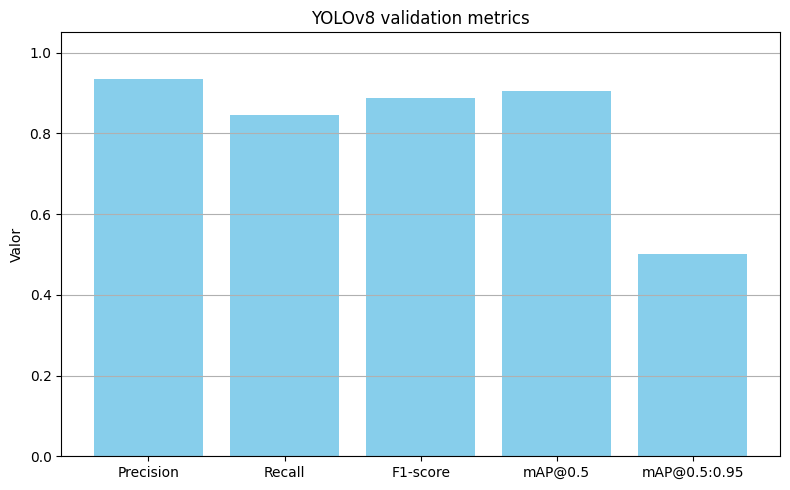


📄 CSV guardado en: /content/metricas_val/metricas_validacion_conf__iou_.csv
🖼️ Gráfico guardado en: /content/metricas_val/metricas_conf__iou_.png


In [21]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from ultralytics import YOLO

# === CONFIGURACIÓN ===
model_path = "/content/best_coseno_z_25.pt"
data_yaml = "/content/export_yolov8/data.yaml"
OUTPUT_DIR = "/content/metricas_val"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# === Cargar modelo ===
model = YOLO(model_path)

# === Ejecutar validación ===
metrics = model.val(data=data_yaml, save_txt=True)

# === Extraer métricas ===
precision = metrics.box.mp
recall = metrics.box.mr
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
map50 = metrics.box.map50
map5095 = metrics.box.map

# === Mostrar métricas por consola ===
print("\n📊 Métricas de validación:")
print(f"✔️ Precision:     {precision:.4f}")
print(f"✔️ Recall:        {recall:.4f}")
print(f"✔️ F1-score:      {f1:.4f}")
print(f"✔️ mAP@0.5:       {map50:.4f}")
print(f"✔️ mAP@0.5:0.95:  {map5095:.4f}")

# === Graficar ===
metric_names = ["Precision", "Recall", "F1-score", "mAP@0.5", "mAP@0.5:0.95"]
metric_values = [precision, recall, f1, map50, map5095]

plt.figure(figsize=(8, 5))
plt.bar(metric_names, metric_values, color='skyblue')
plt.ylim(0, 1.05)
plt.title(f"YOLOv8 validation metrics")
plt.ylabel("Valor")
plt.grid(axis='y')
plt.tight_layout()
plot_path = os.path.join(OUTPUT_DIR, f"metricas_conf__iou_.png")
plt.savefig(plot_path)
plt.show()

# === Exportar CSV ===
csv_path = os.path.join(OUTPUT_DIR, f"metricas_validacion_conf__iou_.csv")
df_metrics = pd.DataFrame({
    "Métrica": metric_names,
    "Valor": metric_values
})
df_metrics.to_csv(csv_path, index=False)
print(f"\n📄 CSV guardado en: {csv_path}")
print(f"🖼️ Gráfico guardado en: {plot_path}")

# 6.3 Best confidence for inference based on F1


Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 790.8±376.4 MB/s, size: 65.5 KB)


val: Scanning /content/export_yolov8/valid/labels.cache... 10008 images, 9838 backgrounds, 0 corrupt: 100%|██████████| 10008/10008 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 626/626 [00:19<00:00, 32.35it/s]


                   all      10008        185      0.934      0.843      0.897      0.542
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val6
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 776.2±413.2 MB/s, size: 39.4 KB)


val: Scanning /content/export_yolov8/valid/labels.cache... 10008 images, 9838 backgrounds, 0 corrupt: 100%|██████████| 10008/10008 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 626/626 [00:19<00:00, 32.75it/s]


                   all      10008        185      0.926      0.873      0.919      0.539
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val7
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 675.1±175.5 MB/s, size: 42.1 KB)


val: Scanning /content/export_yolov8/valid/labels.cache... 10008 images, 9838 backgrounds, 0 corrupt: 100%|██████████| 10008/10008 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 626/626 [00:19<00:00, 32.60it/s]


                   all      10008        185      0.926      0.873      0.918       0.54
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val8
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 513.1±218.7 MB/s, size: 39.2 KB)


val: Scanning /content/export_yolov8/valid/labels.cache... 10008 images, 9838 backgrounds, 0 corrupt: 100%|██████████| 10008/10008 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 626/626 [00:19<00:00, 32.68it/s]


                   all      10008        185      0.926      0.873      0.911      0.541
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val9
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 995.7±242.8 MB/s, size: 71.4 KB)


val: Scanning /content/export_yolov8/valid/labels.cache... 10008 images, 9838 backgrounds, 0 corrupt: 100%|██████████| 10008/10008 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 626/626 [00:18<00:00, 33.06it/s]


                   all      10008        185      0.926      0.873      0.912      0.542
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val10
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 786.1±522.3 MB/s, size: 39.7 KB)


val: Scanning /content/export_yolov8/valid/labels.cache... 10008 images, 9838 backgrounds, 0 corrupt: 100%|██████████| 10008/10008 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 626/626 [00:19<00:00, 32.75it/s]


                   all      10008        185      0.926      0.874      0.911      0.544
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val11
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 896.6±302.9 MB/s, size: 53.7 KB)


val: Scanning /content/export_yolov8/valid/labels.cache... 10008 images, 9838 backgrounds, 0 corrupt: 100%|██████████| 10008/10008 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 626/626 [00:18<00:00, 33.04it/s]


                   all      10008        185      0.925       0.87      0.909      0.544
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val12
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 937.0±564.8 MB/s, size: 49.9 KB)


val: Scanning /content/export_yolov8/valid/labels.cache... 10008 images, 9838 backgrounds, 0 corrupt: 100%|██████████| 10008/10008 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 626/626 [00:19<00:00, 32.82it/s]


                   all      10008        185      0.925       0.87      0.909      0.544
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val13
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 771.4±349.8 MB/s, size: 51.6 KB)


val: Scanning /content/export_yolov8/valid/labels.cache... 10008 images, 9838 backgrounds, 0 corrupt: 100%|██████████| 10008/10008 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 626/626 [00:19<00:00, 32.89it/s]


                   all      10008        185       0.93      0.859      0.904      0.543
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val14
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 966.5±526.8 MB/s, size: 55.6 KB)


val: Scanning /content/export_yolov8/valid/labels.cache... 10008 images, 9838 backgrounds, 0 corrupt: 100%|██████████| 10008/10008 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 626/626 [00:19<00:00, 32.89it/s]


                   all      10008        185      0.935      0.854      0.902      0.541
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val15
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 829.4±266.1 MB/s, size: 55.4 KB)


val: Scanning /content/export_yolov8/valid/labels.cache... 10008 images, 9838 backgrounds, 0 corrupt: 100%|██████████| 10008/10008 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 626/626 [00:19<00:00, 32.81it/s]


                   all      10008        185      0.934      0.843      0.897      0.542
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val16
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 806.4±213.8 MB/s, size: 42.0 KB)


val: Scanning /content/export_yolov8/valid/labels.cache... 10008 images, 9838 backgrounds, 0 corrupt: 100%|██████████| 10008/10008 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 626/626 [00:19<00:00, 32.22it/s]


                   all      10008        185      0.951      0.827      0.894       0.54
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val17
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 349.0±197.1 MB/s, size: 27.2 KB)


val: Scanning /content/export_yolov8/valid/labels.cache... 10008 images, 9838 backgrounds, 0 corrupt: 100%|██████████| 10008/10008 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 626/626 [00:19<00:00, 32.93it/s]


                   all      10008        185      0.952      0.827       0.89      0.537
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val18
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 507.6±71.4 MB/s, size: 29.3 KB)


val: Scanning /content/export_yolov8/valid/labels.cache... 10008 images, 9838 backgrounds, 0 corrupt: 100%|██████████| 10008/10008 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 626/626 [00:18<00:00, 33.31it/s]


                   all      10008        185      0.956      0.827      0.891      0.539
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val19
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 815.5±393.0 MB/s, size: 37.2 KB)


val: Scanning /content/export_yolov8/valid/labels.cache... 10008 images, 9838 backgrounds, 0 corrupt: 100%|██████████| 10008/10008 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 626/626 [00:18<00:00, 33.19it/s]


                   all      10008        185       0.96      0.784      0.871      0.532
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val20
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1086.9±510.6 MB/s, size: 62.7 KB)


val: Scanning /content/export_yolov8/valid/labels.cache... 10008 images, 9838 backgrounds, 0 corrupt: 100%|██████████| 10008/10008 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 626/626 [00:18<00:00, 33.03it/s]


                   all      10008        185      0.959      0.632      0.797      0.503
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val21
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 680.4±308.7 MB/s, size: 37.0 KB)


val: Scanning /content/export_yolov8/valid/labels.cache... 10008 images, 9838 backgrounds, 0 corrupt: 100%|██████████| 10008/10008 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 626/626 [00:18<00:00, 33.30it/s]


                   all      10008        185          1     0.0865      0.543      0.397
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val22
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 727.0±264.7 MB/s, size: 60.9 KB)


val: Scanning /content/export_yolov8/valid/labels.cache... 10008 images, 9838 backgrounds, 0 corrupt: 100%|██████████| 10008/10008 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 626/626 [00:18<00:00, 33.52it/s]


                   all      10008        185          0          0          0          0
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val23
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 955.5±333.4 MB/s, size: 70.7 KB)


val: Scanning /content/export_yolov8/valid/labels.cache... 10008 images, 9838 backgrounds, 0 corrupt: 100%|██████████| 10008/10008 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 626/626 [00:18<00:00, 33.71it/s]


                   all      10008        185          0          0          0          0
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val24
Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 664.5±376.0 MB/s, size: 39.3 KB)


val: Scanning /content/export_yolov8/valid/labels.cache... 10008 images, 9838 backgrounds, 0 corrupt: 100%|██████████| 10008/10008 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 626/626 [00:18<00:00, 33.86it/s]


                   all      10008        185          0          0          0          0
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val25
📄 Comparación guardada en: /content/threshold_analysis_val/val_threshold_comparison.txt
📝 Markdown guardado en: /content/threshold_analysis_val/val_threshold_comparison.md
📈 Gráfico guardado en: /content/threshold_analysis_val/val_threshold_comparison.png
📊 Curva guardada en: /content/threshold_analysis_val/f1_precision_recall_vs_conf.png


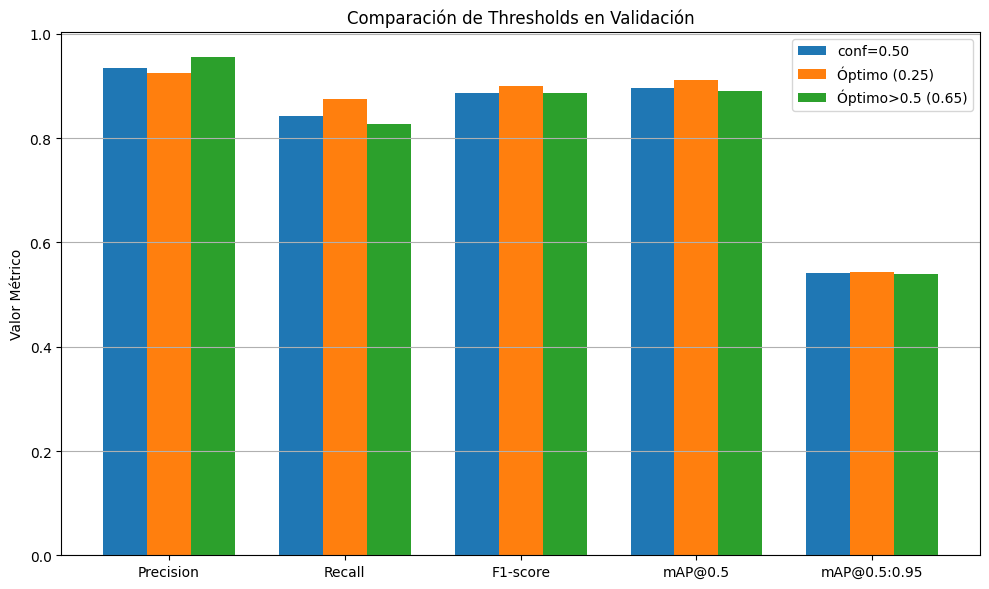

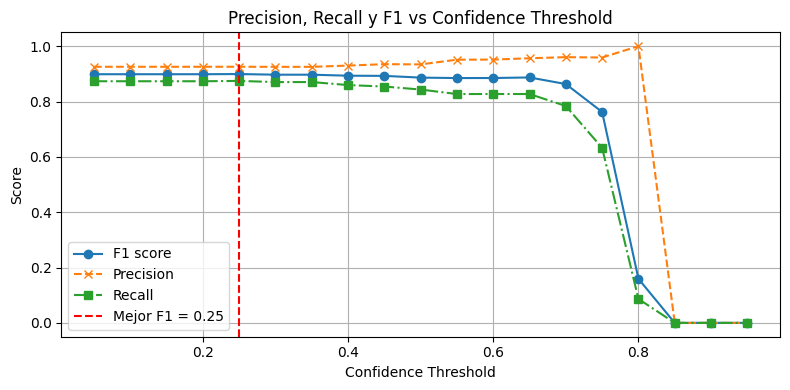

In [9]:
from ultralytics import YOLO
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# === 1. Cargar modelo y dataset ===
model = YOLO("/content/ProSeal/seals2/weights/best.pt")
dataset_yaml = "/content/export_yolov8/data.yaml"

# === 2. Configurar rutas de guardado ===
val_results_dir = "/content/threshold_analysis_val"
os.makedirs(val_results_dir, exist_ok=True)

# === 3. Evaluar baseline (conf=0.50) ===
res_05 = model.val(data=dataset_yaml, split="val", conf=0.5, iou=0.5, verbose=False)
p_05, r_05, map50_05, map95_05 = res_05.box.mean_results()
f1_05 = 2 * p_05 * r_05 / (p_05 + r_05) if (p_05 + r_05) > 0 else 0

# === 4. Buscar best_conf_global (0.05 a 0.95) ===
conf_values = [round(i * 0.05, 2) for i in range(1, 20)]
f1s_all, p_all, r_all, m50_all, m95_all = [], [], [], [], []

for conf in conf_values:
    res = model.val(data=dataset_yaml, split="val", conf=conf, iou=0.5, verbose=False)
    p, r, m50, m95 = res.box.mean_results()
    f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0
    f1s_all.append(f1)
    p_all.append(p)
    r_all.append(r)
    m50_all.append(m50)
    m95_all.append(m95)

best_idx       = int(np.argmax(f1s_all))
best_conf_global = conf_values[best_idx]
p_best, r_best, map50_best, map95_best, f1_best = (
    p_all[best_idx],
    r_all[best_idx],
    m50_all[best_idx],
    m95_all[best_idx],
    f1s_all[best_idx]
)

# === 5. Buscar best_conf_high (solo conf > 0.5) ===
high_start       = conf_values.index(0.55)
conf_values_high = conf_values[high_start:]
f1s_high         = f1s_all[high_start:]
p_high           = p_all[high_start:]
r_high           = r_all[high_start:]
m50_high         = m50_all[high_start:]
m95_high         = m95_all[high_start:]

best_high_idx      = int(np.argmax(f1s_high))
best_conf_high     = conf_values_high[best_high_idx]
p_high_best        = p_high[best_high_idx]
r_high_best        = r_high[best_high_idx]
map50_high_best    = m50_high[best_high_idx]
map95_high_best    = m95_high[best_high_idx]
f1_high_best       = f1s_high[best_high_idx]

# === 6. Crear tabla comparativa ===
comp_data = {
    "Métrica": ["Precision", "Recall", "F1-score", "mAP@0.5", "mAP@0.5:0.95"],
    "conf=0.50": [p_05, r_05, f1_05, map50_05, map95_05],
    f"conf={best_conf_global:.2f}": [p_best, r_best, f1_best, map50_best, map95_best],
    f"conf>{0.50} (mejor={best_conf_high:.2f})": [p_high_best, r_high_best, f1_high_best, map50_high_best, map95_high_best]
}
df_val_comp = pd.DataFrame(comp_data)

# === 7. Guardar .txt ===
txt_path = os.path.join(val_results_dir, "val_threshold_comparison.txt")
with open(txt_path, "w") as f:
    f.write("=== COMPARACIÓN DE 3 THRESHOLDS EN VALIDACIÓN ===\n")
    f.write(f"{'Métrica':<15} | {'conf=0.50':^12} | {'Óptimo global':^16} | {'Óptimo > 0.5':^18}\n")
    f.write("-" * 65 + "\n")
    for i in range(len(df_val_comp)):
        m = df_val_comp.loc[i, "Métrica"]
        v1 = df_val_comp.loc[i, "conf=0.50"]
        v2 = df_val_comp.loc[i, f"conf={best_conf_global:.2f}"]
        v3 = df_val_comp.loc[i, f"conf>{0.50} (mejor={best_conf_high:.2f})"]
        f.write(f"{m:<15} | {v1:.4f}      | {v2:.4f}           | {v3:.4f}\n")
print(f"📄 Comparación guardada en: {txt_path}")

# === 8. Guardar .csv ===
csv_path = os.path.join(val_results_dir, "val_threshold_comparison.csv")
df_val_comp.to_csv(csv_path, index=False)

# === 9. Guardar .md (Markdown) ===
md_path = os.path.join(val_results_dir, "val_threshold_comparison.md")
with open(md_path, "w") as f:
    f.write(f"| Métrica       | conf=0.50 | Óptimo global ({best_conf_global:.2f}) | Óptimo>0.5 ({best_conf_high:.2f}) |\n")
    f.write(f"|---------------|-----------|----------------------|-------------------------|\n")
    for i in range(len(df_val_comp)):
        m  = df_val_comp.loc[i, "Métrica"]
        v1 = df_val_comp.loc[i, "conf=0.50"]
        v2 = df_val_comp.loc[i, f"conf={best_conf_global:.2f}"]
        v3 = df_val_comp.loc[i, f"conf>{0.50} (mejor={best_conf_high:.2f})"]
        f.write(f"| {m:<13} | {v1:.4f}     | {v2:.4f}               | {v3:.4f}                  |\n")
print(f"📝 Markdown guardado en: {md_path}")

# === 10. Gráfico de barras ===
labels = df_val_comp["Métrica"]
x = np.arange(len(labels))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width, df_val_comp["conf=0.50"], width, label="conf=0.50")
ax.bar(x, df_val_comp[f"conf={best_conf_global:.2f}"], width, label=f"Óptimo ({best_conf_global:.2f})")
ax.bar(x + width, df_val_comp[f"conf>{0.50} (mejor={best_conf_high:.2f})"], width,
       label=f"Óptimo>0.5 ({best_conf_high:.2f})")
ax.set_ylabel("Valor Métrico")
ax.set_title("Comparación de Thresholds en Validación")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis="y")
fig.tight_layout()
plot_path = os.path.join(val_results_dir, "val_threshold_comparison.png")
plt.savefig(plot_path)
# plt.show()  # opcional
print(f"📈 Gráfico guardado en: {plot_path}")

# === 11. Curva F1 vs Confidence ===
plt.figure(figsize=(8, 4))
plt.plot(conf_values, f1s_all, marker='o', label='F1 score')
plt.plot(conf_values, p_all,    marker='x', linestyle='--', label='Precision')
plt.plot(conf_values, r_all,    marker='s', linestyle='-.', label='Recall')
plt.axvline(best_conf_global, linestyle='--', color='red',
            label=f'Mejor F1 = {best_conf_global:.2f}')
plt.xlabel('Confidence Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall y F1 vs Confidence Threshold')
plt.grid(True)
plt.legend()
plt.tight_layout()
curve_path = os.path.join(val_results_dir, "f1_precision_recall_vs_conf.png")
plt.savefig(curve_path)
# plt.show()  # opcional
print(f"📊 Curva guardada en: {curve_path}")


# 6.4 Save the validation results

In [10]:

# Define la carpeta de destino en Google Drive
dest_folder = "/content/drive/MyDrive/ProSeal/val/general"
!mkdir -p "{dest_folder}"                                                           #El comando mkdir -p crea esa carpeta (y cualquier subcarpeta necesaria) si no existe.

# Copia la carpeta de resultados (ajusta el nombre según el que se haya generado)
!cp -r /content/runs/detect/val "{dest_folder}/"   #copiar los reultados del modelo en drive


# Comprueba que se copiaron los archivos (opcional)
!ls "{dest_folder}"                                                                 #verifica que los archivos se han copiado correctamente



val


# **7. Evaluation test in Ultralytics**

# 7.1 Evaluate using the ultralytics function in your test set

In [15]:
from ultralytics import YOLO

# 1. Cargar el modelo entrenado
model = YOLO("/content/ProSeal/seals2/weights/best.pt")

# 2. Ejecutar la evaluación sobre el conjunto de test
dataset_yaml = "/content/export_yolov8/data.yaml"

results = model.val(data=dataset_yaml, split="test", save_txt=True, )

# 3. Mostrar las métricas principales
metrics = results.box  # Métricas de bounding boxes

print(f"mAP50:      {metrics.map50:.4f}")
print(f"mAP50-95:   {metrics.map:.4f}")
print(f"Precisión:  {metrics.mp:.4f}")
print(f"Recall:     {metrics.mr:.4f}")

# === TEST POR CLASE ===
# Definir el diccionario de nombres de clase (ajusta según corresponda)
names = {0:  'seal'}
# results.box.maps es un array con el mAP (mAP@0.5:0.95) por cada clase
class_maps = metrics.maps

print("\n=== TEST POR CLASE ===")
for cls_map, name in zip(class_maps, names.values()):
    print(f"{name}: mAP50-95 = {cls_map:.4f}")






Ultralytics 8.3.174 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
Model summary (fused): 72 layers, 11,125,971 parameters, 0 gradients, 28.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 797.0±237.0 MB/s, size: 75.6 KB)


val: Scanning /content/export_yolov8/test/labels.cache... 10007 images, 9837 backgrounds, 0 corrupt: 100%|██████████| 10007/10007 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 626/626 [00:19<00:00, 31.84it/s]


                   all      10007        192      0.944      0.839      0.906      0.542
Speed: 0.2ms preprocess, 1.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val30
mAP50:      0.9059
mAP50-95:   0.5415
Precisión:  0.9440
Recall:     0.8385

=== TEST POR CLASE ===
seal: mAP50-95 = 0.5415


# 7.2 Save test results

In [ ]:

# Define la carpeta de destino en Google Drive
dest_folder = "/content/drive/MyDrive/ProSeal/test"
!mkdir -p "{dest_folder}"                                                           #El comando mkdir -p crea esa carpeta (y cualquier subcarpeta necesaria) si no existe.

# Copia la carpeta de resultados (ajusta el nombre según el que se haya generado)
!cp -r /content/runs/detect/val22 "{dest_folder}/"   #copiar los reultados del modelo en drive


# Comprueba que se copiaron los archivos (opcional)
!ls "{dest_folder}"